<a href="https://colab.research.google.com/github/TasnubaS/Random-Solutions/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Download the Data

In [ ]:
import urllib.request
url = "https://yangfengji.net/uva-nlp-course/code/sst.zip"
filename, headers = urllib.request.urlretrieve(url, filename="sst.zip")
print("DONE")

!unzip sst.zip

DONE
Archive:  sst.zip
   creating: sst/
  inflating: sst/tst.tsv             
  inflating: sst/dictionary.txt      
  inflating: sst/val.tsv             
  inflating: sst/trn.tsv             


# 1. Data Preprocessing with Sklearn

First, we need to load the necessary packages for data preprocessing. In this case, we will use [Sklearn](), which provides some functions for us to create the bag-of-words representations easily. 

In [ ]:
# Load packages

from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

## 1.1 Loading Data

We are going to use the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) corpus. This is a benchmark dataset, which has been used in many text classification papers in NLP. In this project, we will use the binary classification case, where the dataset for this case is often referred as **SST-2**.

We followed the stanard splits offered by this dataset to create 

1. training set (trn_)
2. validation set (val_)
3. test set (tst_)

In [ ]:
def load_data(fname):
    texts, labels = [], []
    with open(fname, 'r') as fin:
        for line in fin:
            items = line.strip().split("\t")
            texts.append(items[1])
            labels.append(int(items[0]))
    print("Reading {} examples from: {}".format(len(texts), fname))
    return texts, labels

Load the data and verify the size of each split

In [ ]:
# Load data
trn_texts, trn_labels = load_data("sst/trn.tsv")
val_texts, val_labels = load_data("sst/val.tsv")
tst_texts, tst_labels = load_data("sst/tst.tsv")

Reading 8256 examples from: sst/trn.tsv
Reading 2171 examples from: sst/val.tsv
Reading 1084 examples from: sst/tst.tsv


## 1.2 Constructing BoW Representations

[CountVectorizer]() defines a class that can build a feature vocab and convert texts to numeric vectors based on that vocab. The class constructor has some important parameters

- *lowercase*: convert all characters to lowercase before tokenizing.
- *min_df*: when building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
- *max_df*: when building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). 
- *ngram_range*: The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.

It provides two basic functions for constructing numeric repersentations of texts

- **fit**: read a list of texts, build a vocab from these texts for future use
- **fit_transform**: read a list of texts, build a vocab from these texts and then convert them into numeric vectors.
- **transform**: read a list of texts and convert them into numeric vectors (it only works after call the **fit** function or the **fit_transform**

In [ ]:
vectorizer = CountVectorizer(lowercase=True, min_df=1, max_df=1.0, ngram_range=(1,1))
trn_data = vectorizer.fit_transform(trn_texts)
val_data = vectorizer.transform(val_texts)
tst_data = vectorizer.transform(tst_texts)

# Some basic information about data
vocab = vectorizer.vocabulary_
print("Vocab size = {}".format(len(vocab)))
print("Size of training data = {}".format(trn_data.shape))
print("Size of val data = {}".format(val_data.shape))
print("Size of test data = {}".format(tst_data.shape))

Vocab size = 15248
Size of training data = (8256, 15248)
Size of val data = (2171, 15248)
Size of test data = (1084, 15248)


## 1.3 Word Frequency Analysis

As explained in the course lecture, Zipf's law is an empirical law of word frequency in a corpus. It represents the relationship between the rank of a word and its frequency as 
$$f(w_t) \propto \frac{1}{r_t}$$

In this section, we can verify this empirical law with the SST data.

Text(0, 0.5, 'word frequency')

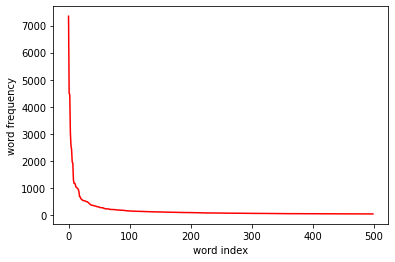

In [ ]:
word_counts = trn_data.sum(axis=0).tolist()[0]
sorted_word_counts = [i for i in sorted(enumerate(word_counts), key=lambda x:x[1], reverse=True)]
ivocab = {val:key for (key, val) in vocab.items()}
plt.plot(range(len(ivocab))[:500], [v[1] for v in sorted_word_counts][:500], color="red") # Only the top 500 words
plt.xlabel("word index")
plt.ylabel("word frequency")

# 2. Classification with Logistic Regression

Import the **LogisticRegression** class from **sklearn.linear_model** as the classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

The class constructor of **LogisticRegression** has some important parameters

- *fit_intercept*: specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
- *penalty*: used to specify the norm used in the penalization.
- *C*: inverse of regularization strength $C=\frac{1}{\lambda}$; must be a positive float.
- *max_iter*: maximum number of iterations taken for the solvers to converge.

In [ ]:
# define a LR classifier

classifier = LogisticRegression(fit_intercept=True, penalty="l2", C=1000, max_iter=200)
classifier.fit(trn_data, trn_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Measure the performance on training and dev data
print("Training accuracy = {}".format(classifier.score(trn_data, trn_labels)))
print("Val accuracy = {}".format(classifier.score(val_data, val_labels)))

Training accuracy = 0.9998788759689923
Val accuracy = 0.5310916628281898


## 2.1 Classification Weight Analysis

In this section, we will look into the classifiers and find out the components of a Logistic Regression classifier in the lecture.

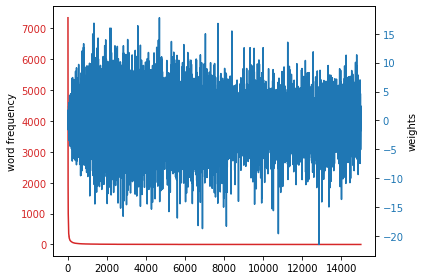

In [ ]:
FIRST=15000

weights = classifier.coef_.flatten()
word_counts = trn_data.sum(axis=0).tolist()[0]
sorted_word_counts = [i for i in sorted(enumerate(word_counts), key=lambda x:x[1], reverse=True)]
ivocab = {val:key for (key, val) in vocab.items()}

fig, ax1 = plt.subplots()

# Draw word frequency
color = "tab:red"
ax1.set_xlabel("")
ax1.set_ylabel("word frequency")
ax1.plot(range(len(ivocab))[:FIRST], [v[1] for v in sorted_word_counts][:FIRST], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color= "tab:blue"
ax2.set_ylabel("weights")
ax2.plot(range(len(ivocab))[:FIRST], [weights[v[0]] for v in sorted_word_counts][:FIRST], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# 3. Homework
